# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Your code here
df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [5]:
experiment = df[df['group'] == 'experiment']['action']
control = df[df['group'] == 'control']['action']

In [8]:
control.describe()

count     4264
unique       2
top       view
freq      3332
Name: action, dtype: object

In [27]:
control.value_counts()

view     3332
click     932
Name: action, dtype: int64

In [7]:
experiment.describe()

count     3924
unique       2
top       view
freq      2996
Name: action, dtype: object

In [28]:
experiment.value_counts()

view     2996
click     928
Name: action, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Control Group')

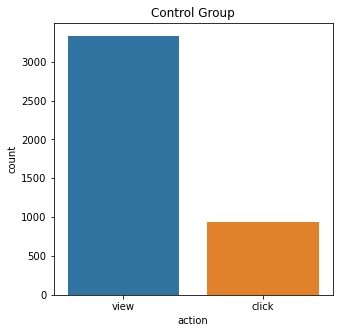

In [42]:
plt.figure(figsize = (5, 5))
sns.countplot(control)
plt.title('Control Group')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Experiment Group')

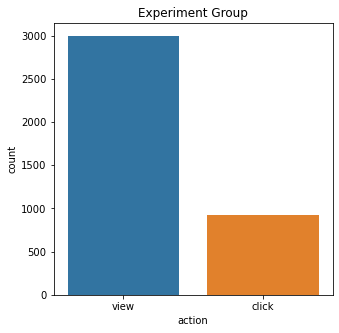

In [43]:
plt.figure(figsize = (5, 5))
sns.countplot(experiment)
plt.title('Experiment Group')

In [38]:
control_id = set(df[df['group'] == 'control']['id'].unique())
experiment_id = set(df[df['group'] == 'experiment']['id'].unique())
print('Overlapping between control and experiment groups: {}'.format(len(control_id & experiment_id)))

Overlapping between control and experiment groups: 0


In [41]:
click_id = set(df[df['action'] == 'click']['id'].unique())
view_id = set(df[df['action'] == 'view']['id'].unique())
print('Number of clickers: {}'.format(len(click_id)))
print('Number of viewers: {}'.format(len(view_id)))
print('Number of clickers who did not view: {}'.format(len(click_id - view_id)))
print('Number of viewers who did not click: {}'.format(len(view_id - click_id)))

Number of clickers: 1860
Number of viewers: 6328
Number of clickers who did not view: 0
Number of viewers who did not click: 4468


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [44]:
df['count'] = 1
df.head()

,timestamp,id,group,action,count
0,2016-09-24 17:42:27.839496,804196,experiment,view,1
1,2016-09-24 19:19:03.542569,434745,experiment,view,1
2,2016-09-24 19:36:00.944135,507599,experiment,view,1
3,2016-09-24 19:59:02.646620,671993,control,view,1
4,2016-09-24 20:26:14.466886,536734,experiment,view,1


In [47]:
#convert clicks into binary variable on a user-by-user basis
control = df[df['group'] == 'control'].pivot(index = 'id', columns = 'action', values = 'count')
control = control.fillna(value = 0)
control.head(10)

action,click,view
id,,
182994,1.0,1.0
183089,0.0,1.0
183248,1.0,1.0
183515,0.0,1.0
183524,0.0,1.0
183576,0.0,1.0
183617,1.0,1.0
184212,1.0,1.0
184390,0.0,1.0


In [49]:
experiment = df[df['group'] == 'experiment'].pivot(index = 'id', columns = 'action', values = 'count')
experiment = experiment.fillna(value = 0)
experiment.head(10)

action,click,view
id,,
182988,0.0,1.0
183136,0.0,1.0
183141,1.0,1.0
183283,0.0,1.0
183389,0.0,1.0
183850,0.0,1.0
183938,1.0,1.0
183988,0.0,1.0
184368,0.0,1.0


In [50]:
print('Sample Size: \tControl: {} \tExperiment: {}'.format(len(control), len(experiment)))

Sample Size: 	Control: 3332 	Experiment: 2996


In [51]:
print('Total Click: \tControl: {} \tExperiment: {}'.format(control['click'].sum(), experiment['click'].sum()))

Total Click: 	Control: 932.0 	Experiment: 928.0


In [53]:
print('Click Average: \tControl: {} \tExperiment: {}'.format(control['click'].mean(), experiment['click'].mean()))

Click Average: 	Control: 0.2797118847539016 	Experiment: 0.3097463284379172


In [61]:
#flatiron_stats
import numpy as np
import scipy.stats as stats

def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. This function returns the degrees of freedom """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def p_value_welch_ttest(a, b, two_sided=False):
    """Calculates the p-value for Welch's t-test given two samples.
    By default, the returned p-value is for a one-sided t-test. 
    Set the two-sided parameter to True if you wish to perform a two-sided t-test instead.
    """
    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [62]:
#Your code here
p_value_welch_ttest(control['click'], experiment['click'])

0.004466402814337078

In [ ]:
#p-value is lower than 0.05 hence there is a statistical significant different between control and experiment group

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [64]:
#same click-through rate as that of the control group
control_mean = control['click'].mean()
expected_experiment_click_under_null = control_mean * len(experiment)
expected_experiment_click_under_null

838.0168067226891

### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [65]:
#expected experiment
experiment_mean = control_mean
experiment_variance = experiment_mean * (1 - experiment_mean) * len(experiment)
experiment_std = np.sqrt(experiment_variance)
experiment_std

24.568547907005815

In [67]:
#observed experiment
observed_experiment_click = experiment['click'].sum()
z_score = (observed_experiment_click - expected_experiment_click_under_null) / experiment_std
z_score

3.6625360854823588

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [69]:
#Your code here
import scipy.stats as stats
p_val = stats.norm.sf(z_score) #sf = survival function = 1 - cdf
p_val

0.00012486528006951198

In [70]:
#alternative
p_val = 1 - stats.norm.cdf(z_score)
p_val

0.00012486528006949715

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **p-value is lower than 0.05. The experiment page is statistically more effective than the control page**

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.